In [3]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
    
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [4]:
dataset = 'photo'
path = osp.join(osp.dirname(osp.realpath('__file__')), 'data', dataset)
dataset = Amazon(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [3]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: AmazonPhoto():
Number of graphs: 1
Number of features: 745
Number of classes: 8


In [4]:
data = dataset[0]  # Get the first graph object.

if not hasattr(data, 'train_mask'):
    # Number of nodes
    num_nodes = data.num_nodes
    
    # Init training, validation and test masks: [False, ..., False]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    
    train_index = round(num_nodes*0.6)
    valid_index = round(train_index + num_nodes*0.2)
    
    print(train_index)
    
    train_mask[ :train_index] = True             # 60% train
    val_mask[train_index:valid_index] = True     # 20% validation
    test_mask[valid_index: ] = True              # 20% test
    
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    
    

print(data)

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

4590
Data(edge_index=[2, 238162], test_mask=[7650], train_mask=[7650], val_mask=[7650], x=[7650, 745], y=[7650])
Data(edge_index=[2, 238162], test_mask=[7650], train_mask=[7650], val_mask=[7650], x=[7650, 745], y=[7650])
Number of nodes: 7650
Number of edges: 238162
Average node degree: 31.13
Number of training nodes: 4590
Number of validation nodes: 1530
Number of testing nodes: 1530
Training node label rate: 0.60
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


In [5]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[   0, 1210],
        [   0, 2198],
        [   0, 2239],
        ...,
        [7649, 2239],
        [7649, 3295],
        [7649, 4196]])


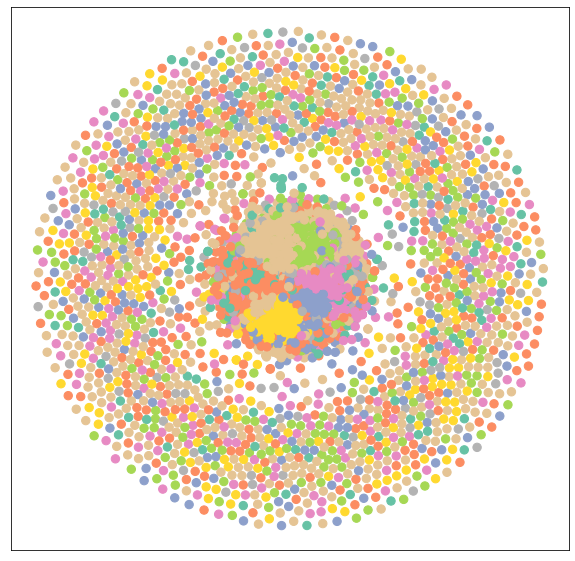

In [6]:
visualize(data.x, color=data.y)

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()

        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
labels = data.y.clone().detach().cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [9]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return out

In [10]:
@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs

In [11]:
for epoch in range(1, 201):
    out = train(data)
    train_acc, val_acc, test_acc = test(data)
    if epoch % 10 == 0:
        #visualize(out, color=labels)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 010, Train: 0.2553, Val: 0.2490, Test: 0.2536
Epoch: 020, Train: 0.2562, Val: 0.2490, Test: 0.2562
Epoch: 030, Train: 0.2553, Val: 0.2490, Test: 0.2542
Epoch: 040, Train: 0.3111, Val: 0.3131, Test: 0.3085
Epoch: 050, Train: 0.3972, Val: 0.4020, Test: 0.3941
Epoch: 060, Train: 0.4349, Val: 0.4425, Test: 0.4373
Epoch: 070, Train: 0.4516, Val: 0.4627, Test: 0.4595
Epoch: 080, Train: 0.4301, Val: 0.4379, Test: 0.4373
Epoch: 090, Train: 0.4342, Val: 0.4399, Test: 0.4405
Epoch: 100, Train: 0.4577, Val: 0.4575, Test: 0.4582
Epoch: 110, Train: 0.4922, Val: 0.4941, Test: 0.4974
Epoch: 120, Train: 0.5063, Val: 0.5065, Test: 0.5105
Epoch: 130, Train: 0.5322, Val: 0.5314, Test: 0.5353
Epoch: 140, Train: 0.6028, Val: 0.6111, Test: 0.6020
Epoch: 150, Train: 0.6192, Val: 0.6255, Test: 0.6235
Epoch: 160, Train: 0.6383, Val: 0.6438, Test: 0.6399
Epoch: 170, Train: 0.6508, Val: 0.6556, Test: 0.6536
Epoch: 180, Train: 0.6741, Val: 0.6791, Test: 0.6693
Epoch: 190, Train: 0.7017, Val: 0.7098, Test: 

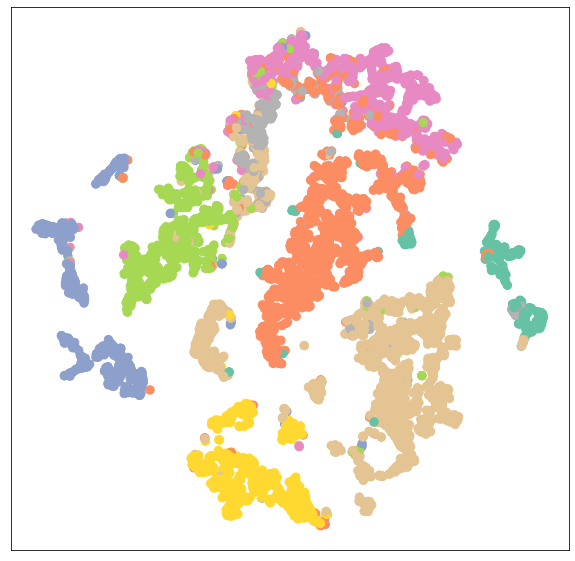

In [12]:
out = model(data.x, data.edge_index)
visualize(out, color=labels)